# Mod03_MBTI Classification Project (NLP
__Contributors: Grace Jeong, Jason Wang__
***

### Objective:
Using Kaggle's dataset of comments scraped from members of PersonalityCafe Forum who have self-identified their MBTI type, create a model that can best predict MBTI based on text data.

### Skills used:
- Text feature engineering (TfIDF, stopwords removal, lemmatization, regex)
- Classification models (Multinomial Naive Bayes, Random Forest, Xgboost, Stochastic Gradient Descent, Support Vector Machine Classifier)
- GridSearch for optimization
- ROC-AUC graphs
- Confusion matrices

***

## --Prepocessing--
### Import libraries and data

In [51]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# import py file that contains helper functions
from helpers import count_caps, count_exclamations, count_digits, count_emojis_shortcode, show_cf, show_roc_graph

In [52]:
# import dataset
df_mbti = pd.read_csv('mbti_1.csv')

In [53]:
# get shape of datatset
df_mbti.shape

(8675, 2)

In [54]:
# preview data
df_mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [55]:
# preview sample raw text data
df_mbti.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [56]:
# create variable containing labels (16 unique categories)
categories = df_mbti.type.values
categories = list(set(categories))

In [57]:
# view distritubtion of observations by class type
df_mbti.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

Text(0.5, 1.0, 'Count of Each MBTI Type')

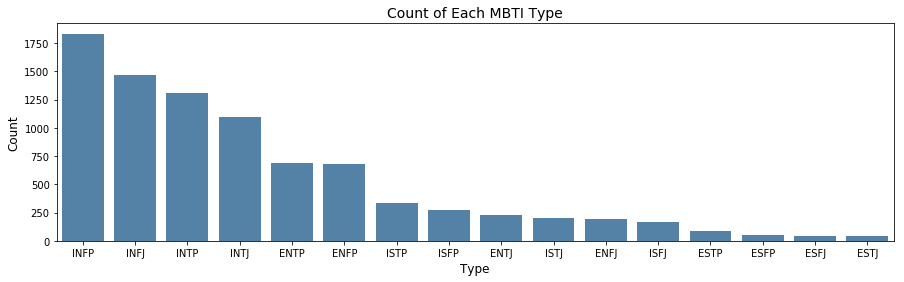

In [58]:
# create graph with count of each class type in the dataset
fig = plt.figure(figsize = (15,4))
sns.barplot(df_mbti.type.value_counts().index, df_mbti.type.value_counts(), color = 'steelblue', label = 'Sample')
plt.xlabel('Type', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Count of Each MBTI Type', fontsize = 14)

As we can see in the graph above, we will be dealing with class imbalance.
***

### Get metadata on raw text
- count of emojis
- count of capitalized letters
- count of exclamations
- count of digits

In [59]:
# list containing the most common emojis
emojis = [':)', ':]', ':|',':[',':(',';)',':/',':o',':O',':D',':&',":')",":'(",':`(','XD',
          ':X','8X','K0',':p','=O','O:)','>:)','>:(','%p',':@)','=^.^=','ó¿ò','ô¿ô','°¿°','©¿©', "'¿'", '?:)',
          '?:~)','?8)','8^)','B)','=D',':|','=)','=.=','^_^','^_','^_~','¬_¬','>_<','o_o','O.O''o.O', "''",
          'x_x','\\m/><\\m/','ಠ_ಠ',':*','9_9','QQ',':-)',':-]',':-|',':-[',':-(',';-)',':-/',':-o',':-O',':-D',
          ':-&',":'-)",":'-(",':`-(','X-D',':-X','8-X','K-0',':-p','=O','O:-)','>:-)','>:-(','%-p',':@)','=^.^=',
          'ó¿ò','ô¿ô','°¿°','©¿©',"'¿'",'?:-)','?:~)','?8-)','8^)','B-)','=D',':|','=)','=.=','^_^','^_-','^_~',
          '¬_¬','>_<','o_o','O.O','o.O',"'-'",'x_x','\\m/><\\m/','ಠ_ಠ',':*','9_9','QQ','@.@']

In [60]:
def count_emojis_shortcode(text):
    """return count of shortcode emojis in text"""
    shortcodes = re.findall(r'\:[a-z]+\:', str(text))
    return len(shortcodes)

In [61]:
def count_emojis(text):
    """return count of emojis in the emojis list above"""
    counter = 0
    split = text.split(' ')
    for x in emojis:
        counter += sum(x in s for s in split)
    return counter

In [62]:
# create additional features: count of capitalizations, count of exclamations, count of emoj
df_mbti['count_of_caps'] = df_mbti.posts.apply(lambda x: count_caps(x))
df_mbti['count_of_exclamations'] = df_mbti.posts.apply(lambda x: count_exclamations(x))
df_mbti['count_of_digits'] = df_mbti.posts.apply(lambda x: count_digits(x))
df_mbti['count_of_emojis'] = df_mbti.posts.apply(lambda x: count_emojis(x)+count_emojis_shortcode(x))

In [63]:
# preview updated dataframe with added features
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,153,3,109,33
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22
2,INTP,'Good one _____ https://www.youtube.com/wat...,169,4,94,14
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2
4,ENTJ,'You're fired.|||That's another silly misconce...,261,1,41,11


***

### Clean text
- remove hyperlinks, special characters & digits

In [64]:
# clean text: remove hyperlinks, special characters & digits
df_mbti.posts = df_mbti.posts.apply(lambda x: re.sub(r"(http|ftp|https)://([\w+?\.\w+])+([a-zA-Z0-9\~\!\@\#\$\%\^\&\*\(\)_\-\=\+\\\/\?\.\:\;\'\,]*)?", "", x))
df_mbti.posts = df_mbti.posts.apply(lambda x: re.sub(r"\|", "", x))
df_mbti.posts = df_mbti.posts.apply(lambda x: re.sub(r"\d", "", x))
df_mbti.posts = df_mbti.posts.apply(lambda x: re.sub(r"_", "", x))

In [65]:
def lower(text):
    """return list of lower-cased words"""
    return [word.lower() for word in text]

# tokenize comments and lower-case all words
tokenizer = RegexpTokenizer(r'\w+')
df_mbti['tokenized'] = df_mbti.posts.apply(lambda x: tokenizer.tokenize(x))
df_mbti['tokenized'] = df_mbti.tokenized.apply(lambda x: lower(x))

# create list of stopwords
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

def remove_stopwords(tokenized):
    """return only words not in stopwords_list"""
    return [word.lower() for word in tokenized if word not in stopwords_list]

In [66]:
# preview the updated dateframe
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ..."
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ..."
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th..."
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc..."


In [67]:
# add new column with tokens with stopwords removed
df_mbti['tokens_stopped'] = df_mbti.tokenized.apply(lambda x: remove_stopwords(x))

In [68]:
# preview updated dataframe
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized,tokens_stopped
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ...","[enfp, intj, moments, sportscenter, top, ten, ..."
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ...","[finding, lack, posts, alarming, sex, boring, ..."
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ...","[good, one, course, say, know, blessing, curse..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th...","[dear, intp, enjoyed, conversation, day, esote..."
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc...","[fired, another, silly, misconception, approac..."


In [69]:
# create features of total words and total unique words
df_mbti['num_total_words'] = df_mbti['tokens_stopped'].apply(lambda x: len(x))
df_mbti['num_unique_words'] = df_mbti['tokens_stopped'].apply(lambda x: len(set(x)))

In [70]:
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized,tokens_stopped,num_total_words,num_unique_words
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ...","[enfp, intj, moments, sportscenter, top, ten, ...",307,257
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ...","[finding, lack, posts, alarming, sex, boring, ...",561,403
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ...","[good, one, course, say, know, blessing, curse...",432,342
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th...","[dear, intp, enjoyed, conversation, day, esote...",522,374
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc...","[fired, another, silly, misconception, approac...",482,368


In [71]:
print('Shape of final dataframe is {}'.format(df_mbti.shape))

Shape of final dataframe is (8675, 10)


### Lemmatize stopped tokens

We decided to lemmatize the final list of stopped tokens to reduce redundancy in our vocabulary.

In [72]:
from nltk.stem.wordnet import WordNetLemmatizer

In [73]:
def lemmatize(token_stopwords_list):
    """return a list of lemmatized words"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in token_stopwords_list]


In [74]:
# add new column of lemmatized words in a list
df_mbti['lemmatized'] = df_mbti.tokens_stopped.apply(lambda x: lemmatize(x))

In [75]:
# take the lemmatized results and join them in a string to later pass into vectorizer
df_mbti['joined_lemmatized']= df_mbti['lemmatized'].apply(lambda x: " ".join(x))

In [76]:
# preview updated dataframe
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized,tokens_stopped,num_total_words,num_unique_words,lemmatized,joined_lemmatized
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ...","[enfp, intj, moments, sportscenter, top, ten, ...",307,257,"[enfp, intj, moment, sportscenter, top, ten, p...",enfp intj moment sportscenter top ten play pra...
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ...","[finding, lack, posts, alarming, sex, boring, ...",561,403,"[finding, lack, post, alarming, sex, boring, p...",finding lack post alarming sex boring position...
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ...","[good, one, course, say, know, blessing, curse...",432,342,"[good, one, course, say, know, blessing, curse...",good one course say know blessing curse absolu...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th...","[dear, intp, enjoyed, conversation, day, esote...",522,374,"[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc...","[fired, another, silly, misconception, approac...",482,368,"[fired, another, silly, misconception, approac...",fired another silly misconception approaching ...


In [77]:
# view list of columns to identify columns to drop
df_mbti.columns

Index(['type', 'posts', 'count_of_caps', 'count_of_exclamations',
       'count_of_digits', 'count_of_emojis', 'tokenized', 'tokens_stopped',
       'num_total_words', 'num_unique_words', 'lemmatized',
       'joined_lemmatized'],
      dtype='object')

In [78]:
# create new dataframe with just the columns we want for our models
df_mbti_dropped = df_mbti[['type','count_of_caps', 'count_of_exclamations','count_of_digits', 
                           'count_of_emojis', 'num_total_words', 'num_unique_words', 
                           'joined_lemmatized']]

In [79]:
# preview new dataframe
df_mbti_dropped.head()

,type,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,num_total_words,num_unique_words,joined_lemmatized
0,INFJ,153,3,109,33,307,257,enfp intj moment sportscenter top ten play pra...
1,ENTP,327,0,109,22,561,403,finding lack post alarming sex boring position...
2,INTP,169,4,94,14,432,342,good one course say know blessing curse absolu...
3,INTJ,253,3,33,2,522,374,dear intp enjoyed conversation day esoteric ga...
4,ENTJ,261,1,41,11,482,368,fired another silly misconception approaching ...


In [80]:
# save our new dataframe as csv as backup
# df_mbti_dropped.to_csv('master_df.csv')

In [81]:
# create list of our entire corpus' vocabulary
all_lemmatized_posts=[]
for x in df_mbti.lemmatized:
    all_lemmatized_posts.extend(x)
    
all_lemmatized_posts

['enfp',
 'intj',
 'moment',
 'sportscenter',
 'top',
 'ten',
 'play',
 'prankswhat',
 'life',
 'changing',
 'experience',
 'life',
 'repeat',
 'today',
 'may',
 'perc',
 'experience',
 'immerse',
 'last',
 'thing',
 'infj',
 'friend',
 'posted',
 'facebook',
 'committing',
 'suicide',
 'next',
 'day',
 'rest',
 'peace',
 'hello',
 'enfj',
 'sorry',
 'hear',
 'distress',
 'natural',
 'relationship',
 'perfection',
 'time',
 'every',
 'moment',
 'existence',
 'try',
 'figure',
 'hard',
 'time',
 'time',
 'growth',
 'welcome',
 'stuff',
 'game',
 'set',
 'match',
 'prozac',
 'wellbrutin',
 'least',
 'thirty',
 'minute',
 'moving',
 'leg',
 'mean',
 'moving',
 'sitting',
 'desk',
 'chair',
 'weed',
 'moderation',
 'maybe',
 'try',
 'edible',
 'healthier',
 'alternative',
 'basically',
 'come',
 'three',
 'item',
 'determined',
 'type',
 'whichever',
 'type',
 'want',
 'would',
 'likely',
 'use',
 'given',
 'type',
 'cognitive',
 'function',
 'whatnot',
 'left',
 'thing',
 'moderation',
 '

In [82]:
from  nltk import FreqDist
freqdist = FreqDist(all_lemmatized_posts)

# get the 200 most common words 
most_common = freqdist.most_common(200)

In [83]:
most_common

[('like', 71077),
 ('think', 50948),
 ('people', 48145),
 ('one', 40171),
 ('know', 38284),
 ('really', 35257),
 ('would', 34996),
 ('thing', 34553),
 ('time', 33622),
 ('get', 33333),
 ('feel', 25712),
 ('type', 24019),
 ('make', 23643),
 ('much', 23067),
 ('say', 22693),
 ('well', 22591),
 ('friend', 22132),
 ('way', 21759),
 ('love', 21739),
 ('want', 21194),
 ('good', 20722),
 ('see', 19532),
 ('something', 19486),
 ('also', 18286),
 ('lot', 18181),
 ('go', 17439),
 ('even', 16902),
 ('always', 16796),
 ('life', 16462),
 ('someone', 16231),
 ('could', 15275),
 ('never', 15231),
 ('though', 14557),
 ('find', 14387),
 ('year', 14360),
 ('thought', 13967),
 ('need', 13577),
 ('actually', 13168),
 ('infp', 13123),
 ('person', 13008),
 ('work', 12891),
 ('right', 12886),
 ('going', 12711),
 ('first', 12618),
 ('sure', 12570),
 ('pretty', 12310),
 ('yes', 12069),
 ('infj', 12048),
 ('mean', 12028),
 ('feeling', 11605),
 ('intj', 11579),
 ('take', 11521),
 ('day', 11516),
 ('come', 11298)

In [84]:
print("There are {} unique words in the corpus.".format(len(freqdist)))

There are 112320 unique words in the corpus.


## --Modeling--

Models to run:<br>
1) Multinomial Naive Bayes (default values as the baseline model) <br>
2) Random Forest<br>
3) SVC<br>
4) XgBoost<br>
5) Stochastic Gradient Descent

### Vectorize text using TfIDF for training and test sets

Setting random_state = 10 to compare model with other models. Stratify = y to account for class imbalance (ensures similar ratio of each class exists in the train and test sets).

In [85]:
# train-test-split data
x = df_mbti.joined_lemmatized
y = df_mbti.type
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    shuffle = True, 
                                                    random_state = 10, 
                                                    stratify = y)


In [86]:
# vectorize X_train and X_test
vectorizer = TfidfVectorizer()
tfidf_x_train = vectorizer.fit_transform(x_train)
tfidf_x_test = vectorizer.transform(x_test)

### 1) Multinomial Naive Bayes Classifier (Baseline Model)

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [88]:
# create & run multinomialNB classifier on x_train set
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_x_train, y_train)
nb_train_preds = nb_classifier.predict(tfidf_x_train)
nb_train_score = accuracy_score(y_train, nb_train_preds)
print("Baseline MultinomialNB Classifer (train) accuracy score: ",nb_train_score)

Baseline MultinomialNB Classifer (train) accuracy score:  0.2148414985590778


In [89]:
# run multinomialBN on x_test set
nb_test_preds = nb_classifier.predict(tfidf_x_test)
nb_test_score = accuracy_score(y_test, nb_test_preds)
print("Baseline MultinomialNB Classifer (test) accuracy score: ",nb_test_score)

Baseline MultinomialNB Classifer (test) accuracy score:  0.21152737752161382


In [115]:
# function to return confusion matrix and classification report
def get_model_data(y_test, y_preds, model_name):
    """return confusion matrix and classifiation report on test set for a given model"""
    categories = ['INFP', 'ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP']
    cf = confusion_matrix(y_test, y_preds)
    show_cf(y_test, y_preds, model_name=model_name)
    print (classification_report(y_test, y_preds, target_names=categories))

In [91]:
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

        INFP       0.00      0.00      0.00        38
        ENFJ       0.00      0.00      0.00       135
        ENFP       0.00      0.00      0.00        46
        ENTJ       0.00      0.00      0.00       137
        ENTP       0.00      0.00      0.00         8
        ESFJ       0.00      0.00      0.00        10
        ESFP       0.00      0.00      0.00         8
        ESTJ       0.00      0.00      0.00        18
        ESTP       0.50      0.00      0.01       294
        INFJ       0.21      1.00      0.35       367
        INTJ       0.00      0.00      0.00       218
        INTP       0.00      0.00      0.00       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.00      0.00      0.00        67

   micro avg       0.21      0.21      0.21      1735
   macro avg       0.04   

/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NameError: name 'cr' is not defined

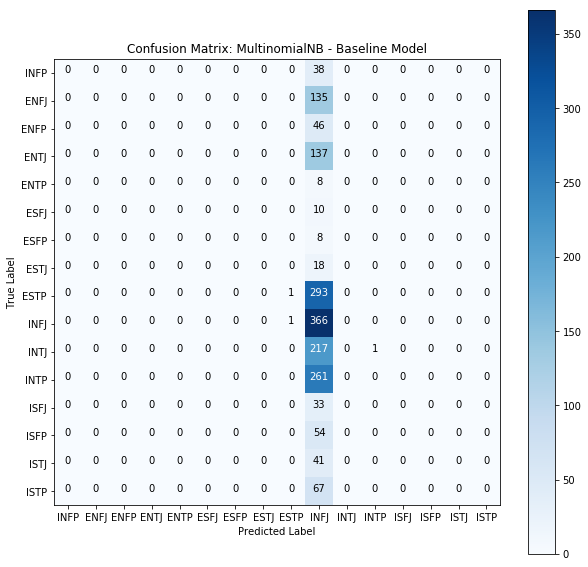

In [92]:
# get confusion matrix and classification report for model
get_model_data(y_test, nb_test_preds, 'MultinomialNB - Baseline Model')

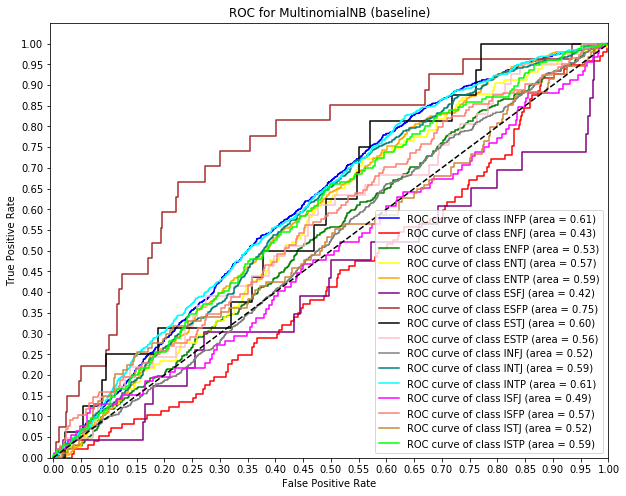

In [46]:
# create multiclass ROC-curve for multinomial NB
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
    
classes = ['INFP', 'ENFJ', 'ENFP', 'ENTJ', 'ENTP',
            'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ',
            'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ',
            'ISTP']

y_bin = label_binarize(y, classes=classes)

X_train, X_test, y_train, y_test = train_test_split(x, y_bin, test_size=.5, random_state=0)

tfidf_x_train = vectorizer.fit_transform(X_train)
tfidf_x_test = vectorizer.transform(X_test)


classifier = OneVsRestClassifier(nb_classifier)
y_score = classifier.fit(tfidf_x_train, y_train).predict_proba(tfidf_x_test)


n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'black', 'pink', 'grey', 'teal',
                   'cyan', 'magenta', 'salmon', 'peru', 'lime']
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for MultinomialNB (baseline)')
plt.legend(loc="lower right")
plt.show()


## Random Forest (different test_sizes)

In [96]:
def random_forest(test_size):
    """return train and test accuracy score for random forest classifier at various test_size"""
    x = df_mbti.joined_lemmatized
    y = df_mbti.type
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, shuffle = True, random_state = 10, stratify = y)
    
    vectorizer = TfidfVectorizer()
    tfidf_x_train = vectorizer.fit_transform(x_train)
    tfidf_x_test = vectorizer.transform(x_test)
    
    rf_classifier = RandomForestClassifier(n_estimators = 100)
    rf_classifier.fit(tfidf_x_train, y_train)
    rf_train_preds = rf_classifier.predict(tfidf_x_train)
    rf_test_preds = rf_classifier.predict(tfidf_x_test)
    
    train_accuracy = accuracy_score(y_train, rf_train_preds)
    test_accuracy = accuracy_score(y_test, rf_test_preds)
    
    return train_accuracy, test_accuracy

In [97]:
# create a table of accuracy results for random forest at different test_size
results = []

In [98]:
results.append({'Test size': 0.333, 'Train accuracy': random_forest(0.5)[0], 'Test accuracy': random_forest(0.333)[1]})
results.append({'Test size': 0.4, 'Train accuracy': random_forest(0.5)[0], 'Test accuracy': random_forest(0.4)[1]})
results.append({'Test size': 0.5, 'Train accuracy': random_forest(0.5)[0], 'Test accuracy': random_forest(0.5)[1]})
results.append({'Test size': 0.75, 'Train accuracy': random_forest(0.5)[0], 'Test accuracy': random_forest(0.75)[1]})

In [99]:
rf_results = pd.DataFrame(results)
rf_results

,Test accuracy,Test size,Train accuracy
0,0.395292,0.333,1.0
1,0.376945,0.400,1.0
2,0.390964,0.500,1.0
3,0.384202,0.750,1.0


## Random Forest w/ GridSearch

In [100]:
from sklearn.model_selection import GridSearchCV

In [101]:
x3 = df_mbti.joined_lemmatized
y3 = df_mbti.type
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size = 0.333, shuffle = True, random_state = 10, stratify = y)


In [102]:
vectorizer = TfidfVectorizer()
tfidf_x_train3 = vectorizer.fit_transform(x_train3)
tfidf_x_test3 = vectorizer.transform(x_test3)

In [103]:
rf_clf = RandomForestClassifier()

In [109]:
rf_clf = RandomForestClassifier()

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 1, 2, 5, 10],
    "min_samples_split": [2, 5, 10, 20],
    "n_estimators": [80,100]
}

gs_tree = GridSearchCV(rf_clf, param_grid, cv=3)
gs_tree.fit(tfidf_x_train3, y_train3)

gs_tree.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_split': 10,
 'n_estimators': 100}

In [117]:
def random_forest_gs(criterion, max_depth, min_samples_split, n_estimators):
    x1 = df_mbti.joined_lemmatized
    y1 = df_mbti.type
    x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.333, shuffle = True, random_state = 10, stratify = y)

    vectorizer = TfidfVectorizer()
    tfidf_x_train1 = vectorizer.fit_transform(x1_train)
    tfidf_x_test1 = vectorizer.transform(x1_test)

    rf_classifier = RandomForestClassifier(criterion = criterion, n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split)
    rf_classifier.fit(tfidf_x_train1, y1_train)
    rf_train_preds1 = rf_classifier.predict(tfidf_x_train1)
    rf_test_preds1 = rf_classifier.predict(tfidf_x_test1)

    train_accuracy1 = accuracy_score(y1_train, rf_train_preds1)
    test_accuracy1 = accuracy_score(y1_test, rf_test_preds1)
    
    return train_accuracy1, test_accuracy1, rf_test_preds1, y1_test, rf_classifier

In [118]:
train_accuracy1, test_accuracy1, rf_test_preds1, y1_test, rf_classifier = random_forest_gs('gini', None, 10, 100)

/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        INFP       0.00      0.00      0.00        63
        ENFJ       0.85      0.05      0.09       225
        ENFP       0.00      0.00      0.00        77
        ENTJ       0.73      0.11      0.18       228
        ENTP       0.00      0.00      0.00        14
        ESFJ       0.00      0.00      0.00        16
        ESFP       0.00      0.00      0.00        13
        ESTJ       0.00      0.00      0.00        30
        ESTP       0.46      0.50      0.48       490
        INFJ       0.34      0.91      0.49       610
        INTJ       0.65      0.33      0.44       364
        INTP       0.46      0.50      0.48       434
        ISFJ       0.00      0.00      0.00        55
        ISFP       0.00      0.00      0.00        90
        ISTJ       0.00      0.00      0.00        68
        ISTP       1.00      0.01      0.02       112

   micro avg       0.41      0.41      0.41      2889
   macro avg       0.28   

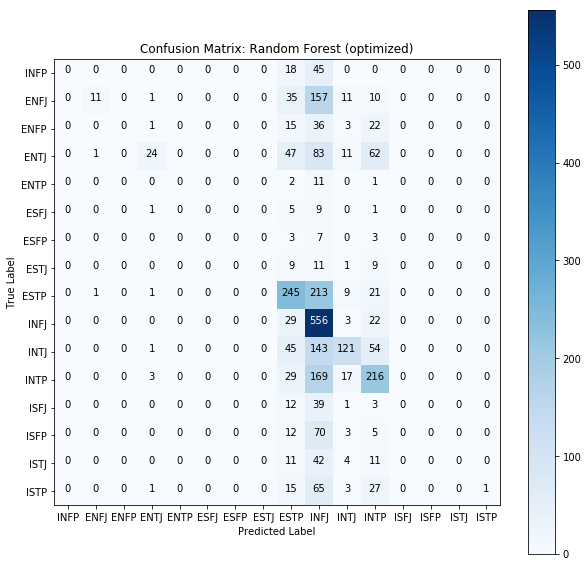

In [116]:
get_model_data(y1_test, rf_test_preds1, "Random Forest (optimized)")

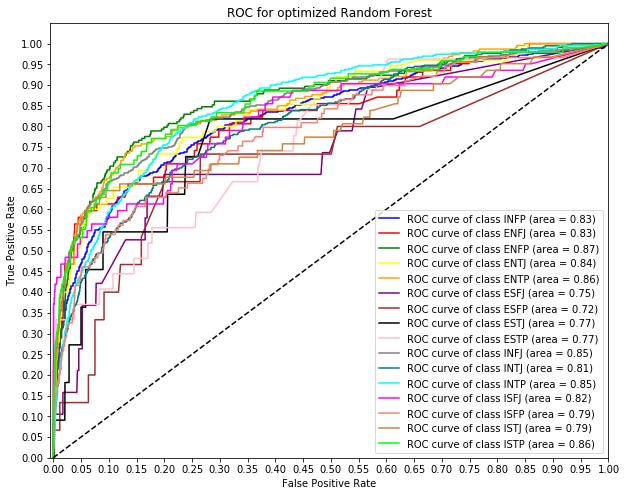

In [119]:
# create multiclass ROC-curve for optimized random forest
    
classes = ['INFP', 'ENFJ', 'ENFP', 'ENTJ', 'ENTP',
            'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ',
            'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ',
            'ISTP']

y_bin = label_binarize(y, classes=classes)

X_train, X_test, y_train, y_test = train_test_split(x, y_bin, test_size=.333, random_state=0)

tfidf_x_train = vectorizer.fit_transform(X_train)
tfidf_x_test = vectorizer.transform(X_test)


classifier = OneVsRestClassifier(rf_classifier)
y_score = classifier.fit(tfidf_x_train, y_train).predict_proba(tfidf_x_test)


n_classes = len(classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'black', 'pink', 'grey', 'teal',
                   'cyan', 'magenta', 'salmon', 'peru', 'lime']
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.005, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for optimized Random Forest')
plt.legend(loc="lower right")
plt.show()


## Decision tree on non-text features

In [97]:
df_mbti.head()

,type,posts,count_of_caps,count_of_exclamations,count_of_digits,count_of_emojis,tokenized,token_stopwords,num_total_words,num_unique_words,lemmatized,joined_lemmatized
0,INFJ,'enfp and intj moments sportscenter not top...,153,3,109,33,"[enfp, and, intj, moments, sportscenter, not, ...","[enfp, intj, moments, sportscenter, top, ten, ...",307,257,"[enfp, intj, moment, sportscenter, top, ten, p...",enfp intj moment sportscenter top ten play pra...
1,ENTP,'I'm finding the lack of me in these posts ver...,327,0,109,22,"[i, m, finding, the, lack, of, me, in, these, ...","[finding, lack, posts, alarming, sex, boring, ...",561,403,"[finding, lack, post, alarming, sex, boring, p...",finding lack post alarming sex boring position...
2,INTP,"'Good one Of course, to which I say I know...",169,4,94,14,"[good, one, of, course, to, which, i, say, i, ...","[good, one, course, say, know, blessing, curse...",432,342,"[good, one, course, say, know, blessing, curse...",good one course say know blessing curse absolu...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",253,3,33,2,"[dear, intp, i, enjoyed, our, conversation, th...","[dear, intp, enjoyed, conversation, day, esote...",522,374,"[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...
4,ENTJ,'You're fired.That's another silly misconcepti...,261,1,41,11,"[you, re, fired, that, s, another, silly, misc...","[fired, another, silly, misconception, approac...",482,368,"[fired, another, silly, misconception, approac...",fired another silly misconception approaching ...


In [61]:
X = df_mbti[["count_of_caps", "count_of_exclamations", "count_of_digits", "count_of_emojis", "num_total_words", "num_unique_words"]]

In [62]:
X.columns

Index(['count_of_caps', 'count_of_exclamations', 'count_of_digits',
       'count_of_emojis', 'num_total_words', 'num_unique_words'],
      dtype='object')

In [63]:
y_tree = df_mbti.type

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y_tree, test_size = 0.333)

In [65]:
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier 

In [106]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_hat_test = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_hat_test)
accuracy

0.1585323641398408

In [107]:
y_hat_train = tree.predict(X_train)


In [108]:
accuracy_train = accuracy_score(y_train, y_hat_train)
accuracy_train

1.0

## Merge vectorized sparse matrix and other features

In [66]:
xm = df_mbti[["joined_lemmatized", "count_of_caps", "count_of_exclamations", "count_of_digits", "count_of_emojis", "num_total_words", "num_unique_words"]]
ym = df_mbti.type
xm_train, xm_test, ym_train, ym_test = train_test_split(xm, 
                                                    ym, 
                                                    test_size = 0.2, 
                                                    shuffle = True, 
                                                    random_state = 10, 
                                                    stratify = y)

In [67]:
vectorizer = TfidfVectorizer()
tfidf_x_trainm = vectorizer.fit_transform(xm_train["joined_lemmatized"])
tfidf_x_testm = vectorizer.transform(xm_test['joined_lemmatized'])

In [68]:
tfidf_x_trainm.shape

(6940, 98345)

In [69]:
features_train = np.array(xm_train[["count_of_caps", "count_of_exclamations", "count_of_digits", "count_of_emojis", "num_total_words", "num_unique_words"]])
features_train

array([[364,   8,  31,   1, 392, 282],
       [262,   2,  21,   6, 784, 615],
       [392,  12,  31,  32, 578, 377],
       ...,
       [283,   0,  16,  14, 641, 439],
       [315,  17,  69,   8, 561, 430],
       [238,   1,  31,  18, 358, 274]])

In [70]:
features_test = np.array(xm_test[["count_of_caps", "count_of_exclamations", "count_of_digits", "count_of_emojis", "num_total_words", "num_unique_words"]])
features_test

array([[224,   2,  56,   8, 417, 329],
       [370,  20, 301,  22, 363, 301],
       [195,   0,  41,  11, 558, 383],
       ...,
       [267,  22,  12,  24, 475, 308],
       [177,   2,  58,  14, 495, 402],
       [334,   1,  17,  14, 664, 467]])

In [71]:
import scipy
merged_matrix_train = scipy.sparse.hstack([tfidf_x_trainm,features_train]).toarray()

In [72]:
merged_matrix_train.shape

(6940, 98351)

In [73]:
merged_matrix_test = scipy.sparse.hstack([tfidf_x_testm,features_test]).toarray()

In [74]:
merged_matrix_test.shape

(1735, 98351)

## Random Forest w/ GridSearch on merged matrix

In [65]:
rf_clf = RandomForestClassifier()

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 1, 2, 5, 10],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [80,100]
}

gs_rf_merged = GridSearchCV(rf_clf, param_grid, cv=3)
gs_rf_merged.fit(merged_matrix_train, ym_train)

gs_rf_merged.best_params_

NameError: name 'GridSearchCV' is not defined

In [260]:
rf_clf2 = RandomForestClassifier(criterion = 'gini', max_depth = None, n_estimators= 80)
rf_clf2.fit(merged_matrix_train, ym_train)
ym_train_preds = rf_clf2.predict(merged_matrix_train)
ym_test_preds = rf_clf2.predict(merged_matrix_test)
acc_score_train = accuracy_score(ym_train, ym_train_preds)
acc_score_test = accuracy_score(ym_test, ym_test_preds)

print(acc_score_train)
print(acc_score_test)

1.0
0.3786743515850144


In [262]:
#NB on merged matrix
nb_classifier1 = MultinomialNB()
nb_classifier1.fit(merged_matrix_train, ym_train)
nb_train_preds1 = nb_classifier1.predict(merged_matrix_train)
nb_train_score1 = accuracy_score(ym_train, nb_train_preds1)
nb_train_score1

0.21138328530259365

In [263]:
nb_test_preds1 = nb_classifier1.predict(merged_matrix_test)
nb_test_score1 = accuracy_score(ym_test, nb_test_preds1)
nb_test_score1

0.21210374639769453

## SVM

In [120]:
from sklearn import svm

In [76]:
def SVM_classifier_matrix(kernel):
    SVM = svm.SVC(C=1.0, kernel = kernel, degree = 3, gamma = 'auto')
    SVM.fit(tfidf_x_trainm, ym_train)
    SVM_preds_test = SVM.predict(tfidf_x_testm)
    SVM_preds_train = SVM.predict(tfidf_x_trainm)
    train_acc = str(round(accuracy_score(SVM_preds_train, ym_train),4)*100)+'%'
    test_acc = str(round(accuracy_score(SVM_preds_test, ym_test),4)*100)+'%'
    SVM_model_sum.append({'Model Name': 'SVM Classifier ({})'.format(kernel),
                  'Training Accuracy': train_acc,
                  'Testing Accuracy': test_acc,
                  'Training F1-Score': str(round(f1_score(ym_train, SVM_preds_train, average = 'micro'),4)*100)+'%',
                  'Testing F1-Score': str(round(f1_score(ym_test, SVM_preds_test, average = 'micro'),4)*100)+'%'})
    return train_acc, test_acc

Test the four different kernels on the SVC.

In [136]:
SVM_classifier_matrix('linear')

('94.16%', '64.78%')

In [137]:
SVM_classifier_matrix('rbf')

('21.11%', '21.15%')

In [138]:
SVM_classifier_matrix('sigmoid')

('21.11%', '21.15%')

In [139]:
SVM_classifier_matrix('poly')

('21.11%', '21.15%')

Create classification report, confusion matrix and ROC-AUC graph for the final SVC model.

/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/gracejeong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

        INFP       0.65      0.24      0.35        55
        ENFJ       0.70      0.58      0.63       215
        ENFP       0.72      0.36      0.48        91
        ENTJ       0.63      0.62      0.62       206
        ENTP       0.60      0.19      0.29        16
        ESFJ       0.00      0.00      0.00        16
        ESFP       0.00      0.00      0.00        15
        ESTJ       0.88      0.25      0.39        28
        ESTP       0.66      0.71      0.68       483
        INFJ       0.63      0.82      0.71       617
        INTJ       0.66      0.70      0.68       373
        INTP       0.64      0.77      0.70       433
        ISFJ       0.92      0.46      0.61        50
        ISFP       0.72      0.31      0.43       100
        ISTJ       0.80      0.36      0.50        66
        ISTP       0.84      0.54      0.65       125

   micro avg       0.66      0.66      0.66      2889
   macro avg       0.63   

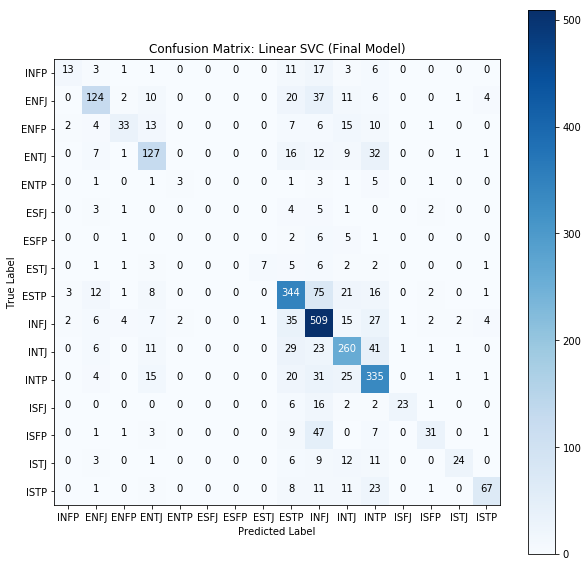

In [127]:
#SVM linear model with text data only
y = df_mbti.type

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.333, random_state = 10, shuffle = True)

tfidf_x_train = vectorizer.fit_transform(X_train)
tfidf_x_test = vectorizer.transform(X_test)

SVC = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVC.fit(tfidf_x_train, y_train)
SVC_preds_test = SVC.predict(tfidf_x_test)

get_model_data(y_test, SVC_preds_test, 'Linear SVC (Final Model)')

In [129]:
# export final model
from sklearn.externals import joblib
import pickle as pkl
joblib.dump(SVC, 'SVC_mbti_finmodel.pkl')

['SVC_mbti_finmodel.pkl']

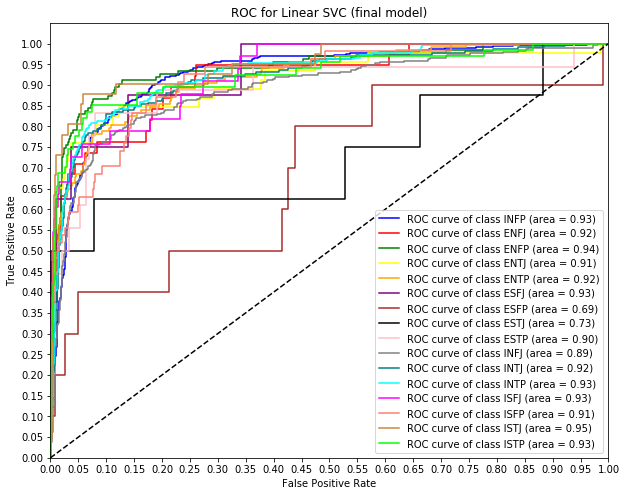

In [134]:
# roc-auc graph for final model
    
classes = ['INFP', 'ENFJ', 'ENFP', 'ENTJ', 'ENTP',
            'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ',
            'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ',
            'ISTP']

y_bin = label_binarize(y, classes=classes)

X_train, X_test, y_train, y_test = train_test_split(x, y_bin, test_size = 0.2, random_state=0, stratify = y)

tfidf_x_train = vectorizer.fit_transform(X_train)
tfidf_x_test = vectorizer.transform(X_test)


n_classes = len(classes)
classifier = OneVsRestClassifier(SVC)
y_score = classifier.fit(tfidf_x_train, y_train).decision_function(tfidf_x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'black', 'pink', 'grey', 'teal',
                   'cyan', 'magenta', 'salmon', 'peru', 'lime']
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Linear SVC (final model)')
plt.legend(loc="lower right")
plt.show()


In [141]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (linear)',
  'Training Accuracy': '94.16%',
  'Testing Accuracy': '64.78%',
  'Training F1-Score': '94.16%',
  'Testing F1-Score': '64.78%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%',
  'Training F1-Score': '21.11%',
  'Testing F1-Score': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%',
  'Training F1-Score': '21.11%',
  'Testing F1-Score': '21.15%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%',
  'Training F1-Score': '21.11%',
  'Testing F1-Score': '21.15%'},
 {'Model Name': 'SVM Classifier (linear, words only)',
  'Training Accuracy': '94.28%',
  'Testing Accuracy': '65.01%',
  'Training F1-Score': '94.28%',
  'Testing F1-Score': '65.01%'}]

In [142]:
df_SVM_sum = pd.DataFrame(SVM_model_sum)
df_SVM_sum

,Model Name,Testing Accuracy,Testing F1-Score,Training Accuracy,Training F1-Score
0,SVM Classifier (linear),64.78%,64.78%,94.16%,94.16%
1,SVM Classifier (rbf),21.15%,21.15%,21.11%,21.11%
2,SVM Classifier (sigmoid),21.15%,21.15%,21.11%,21.11%
3,SVM Classifier (poly),21.15%,21.15%,21.11%,21.11%
4,"SVM Classifier (linear, words only)",65.01%,65.01%,94.28%,94.28%


In [143]:
df_SVM_sum.to_csv('df_SVM_sum.csv')

In [67]:
SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVM.fit(tfidf_x_trainm, ym_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
SVM_preds_test = SVM.predict(tfidf_x_testm)
SVM_preds_train = SVM.predict(tfidf_x_trainm)

In [69]:
accuracy_score(SVM_preds_train, ym_train)

0.94164265129683

In [70]:
accuracy_score(SVM_preds_test, ym_test)

0.6478386167146974

In [119]:
SVM_f1_train_lin = f1_score(ym_train, SVM_preds_train, average = 'micro')
SVM_f1_test_lin = f1_score(ym_test, SVM_preds_test, average = 'micro')

In [123]:
SVM_model_sum[0]['Training F1-Score'] = str(round(SVM_f1_train_lin,4)*100)+'%'
SVM_model_sum[0]['Testing F1-Score'] = str(round(SVM_f1_test_lin,4)*100)+'%'

In [124]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (linear)',
  'Training Accuracy': '94.16%',
  'Testing Accuracy': '64.78%',
  'Training F1-Score': '94.16%',
  'Testing F1-Score': '64.78%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (linear, words only)',
  'Training Accuracy': '94.28%',
  'Testing Accuracy': '65.01%'}]

In [125]:
df_model_sum = pd.DataFrame(SVM_model_sum)

In [126]:
df_model_sum

,Model Name,Testing Accuracy,Testing F1-Score,Training Accuracy,Training F1-Score
0,SVM Classifier (linear),64.78%,64.78%,94.16%,94.16%
1,SVM Classifier (poly),21.15%,NaN,21.11%,NaN
2,SVM Classifier (rbf),21.15%,NaN,21.11%,NaN
3,SVM Classifier (sigmoid),21.15%,NaN,21.11%,NaN
4,SVM Classifier (poly),21.15%,NaN,21.11%,NaN
5,SVM Classifier (rbf),21.15%,NaN,21.11%,NaN
6,SVM Classifier (sigmoid),21.15%,NaN,21.11%,NaN
7,"SVM Classifier (linear, words only)",65.01%,NaN,94.28%,NaN


In [131]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': 0.21109510086455333,
  'Testing Accuracy': 0.21152737752161382}]

In [ ]:
SVM_model_sum[0]['Training F1-Score'] = str(round(SVM_f1_train_lin,4)*100)+'%'
SVM_model_sum[0]['Testing F1-Score'] = str(round(SVM_f1_test_lin,4)*100)+'%'

In [90]:
rbf = SVM_classifier('rbf')

(0.21109510086455333, 0.21152737752161382)

In [91]:
sigmoid = SVM_classifier('sigmoid')

(0.21109510086455333, 0.21152737752161382)

In [93]:
#SVM model (linear) on text data only
SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
SVM.fit(tfidf_x_train, y_train)
SVM_preds_test3 = SVM.predict(tfidf_x_test)
SVM_preds_train3 = SVM.predict(tfidf_x_train)
train_acc3 = accuracy_score(SVM_preds_train3, y_train)
test_acc3 = accuracy_score(SVM_preds_test3, y_test)
SVM_model_sum.append({'Model Name': 'SVM Classifier (kernel = linear; vectorized words only)',
              'Training Accuracy': train_acc3,
              'Testing Accuracy': test_acc3})


NameError: name 'train_acc' is not defined

In [108]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (linear)',
  'Training Accuracy': '94.16%',
  'Testing Accuracy': '64.78%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (kernel = linear; vectorized words only)',
  'Training Accuracy': '94.28%',
  'Testing Accuracy': '65.01%'}]

In [106]:
for i in SVM_model_sum:
    i['Training Accuracy'] = str(round(i['Training Accuracy'],4)*100)+'%'
    i['Testing Accuracy'] = str(round(i['Testing Accuracy'],4)*100)+'%'

TypeError: type str doesn't define __round__ method

In [107]:
SVM_model_sum

[{'Model Name': 'SVM Classifier (linear)',
  'Training Accuracy': '94.16%',
  'Testing Accuracy': '64.78%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (poly)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (rbf)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (sigmoid)',
  'Training Accuracy': '21.11%',
  'Testing Accuracy': '21.15%'},
 {'Model Name': 'SVM Classifier (kernel = linear; vectorized words only)',
  'Training Accuracy': '94.28%',
  'Testing Accuracy': '65.01%'}]

In [109]:
SVM_model_sum[-1]['Model Name'] = 'SVM Classifier (linear, words only)'

In [110]:
df_model_sum = pd.DataFrame(SVM_model_sum)

In [111]:
df_model_sum

,Model Name,Testing Accuracy,Training Accuracy
0,SVM Classifier (linear),64.78%,94.16%
1,SVM Classifier (poly),21.15%,21.11%
2,SVM Classifier (rbf),21.15%,21.11%
3,SVM Classifier (sigmoid),21.15%,21.11%
4,SVM Classifier (poly),21.15%,21.11%
5,SVM Classifier (rbf),21.15%,21.11%
6,SVM Classifier (sigmoid),21.15%,21.11%
7,"SVM Classifier (linear, words only)",65.01%,94.28%


In [115]:
df_model_sum.drop(axis = 0, index = [1,2,3], inplace = True)

KeyError: '[1 2 3] not found in axis'

In [117]:
df_model_sum

,Model Name,Testing Accuracy,Training Accuracy
0,SVM Classifier (linear),64.78%,94.16%
4,SVM Classifier (poly),21.15%,21.11%
5,SVM Classifier (rbf),21.15%,21.11%
6,SVM Classifier (sigmoid),21.15%,21.11%
7,"SVM Classifier (linear, words only)",65.01%,94.28%


In [114]:
df_model_sum.to_csv('SVM_summary.csv')

## Create MBTI predictor function

In [135]:
# load the random forest classifier
SVC_mbti_model = open('svc_mbti_finmodel.pkl','rb')
SVC_clf = joblib.load(SVC_mbti_model)

In [170]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.333, random_state = 10, shuffle = True)

# tfidf_x_train = vectorizer.fit_transform(X_train)
# tfidf_x_test = vectorizer.transform(X_test)


def predict_MBTI(text_string):
    mbti_descriptions = {'ISTP': 'Burning random object', 'INTP':'Reading their book',
                     'INFP': 'Writing their diary', 'ENTJ': 'Looking at the way that is coming',
                     'ISFJ': 'Looking at the way they\'re leaving behind', 'ISTJ': 'Mr. Driver (simultaneously nice and grumpy)',
                     'INFJ': 'Watching everybody and thinking about how crazy humanity is', 'ESTP':'Hesitating the cars coming behind',
                     'ENTP': 'Whispering weird things to ENFP, trying to enter in their subconcious', 'ENFP': 'Got asleep, dreams with some parallel universe',
                     'ENFJ': 'Just met ESFJ and started talking and are super friends now', 'ESFJ': 'Just met ENFJ and started talking and are super friends now',
                     'ISFP': 'Looking to the landscapes, smartphone ready to make some photos', 'INTJ':'Just had a revelation that solves their current project',
                     'ESFP': 'Checking their air in the rearview', 'ESTJ': 'Checking how Mr. Driver drives, sometimes giving him advice'
                    }
    
    tfidf_text = vectorizer.transform([text_string])
    prediction = SVC_clf.predict(tfidf_text)
    result = "".join(prediction)
    print("{}: {}".format(result, mbti_descriptions[result]))
    

In [174]:
text_string = "the Border, or large sections of the Border, next week. This would be so easy for Mexico to do, but they just take our money and “talk.” Besides, we lose so much money with them, especially when you add in drug trafficking etc.), that the Border closing would be a good thing!"
text_string2 = "hahahaha i hope you give them a piece of your mind"
text_string3 = "If you hate the horizontal scroll bar that pops up in jupyter notebook try changing the “automatic” setting to “when scrolling” in system settings -> general. It also seems to fix collapsing cells in case anyone else has run into that problem."
text_string4 = "Here’s what the tables look like. Any chance you could relabel this one?"
text_string5 = "Great to see Chicago’s historic mayoral race between two highly qualified candidates. Congrats to our next mayor, Lori Lightfoot—and Toni Preckwinkle campaigned hard and did us proud. I know that with our city’s heart and Lori’s leadership, Chicago’s best days are still ahead."
text_string6 = "Love, let's talk about love Is it anything and everything you hoped for? Or do the feeling haunt you? I know the feeling haunt you This may be the night that my dreams might let me know All the stars approach you, all the stars approach you, all the stars approach you This may be the night that my dreams might let me know All the stars are closer, all the stars are closer, all the stars are closer"

In [175]:
predict_MBTI(text_string)
predict_MBTI(text_string2)
predict_MBTI(text_string3)
predict_MBTI(text_string4)
predict_MBTI(text_string5)
predict_MBTI(text_string6)

INTP: Reading their book
INFJ: Watching everybody and thinking about how crazy humanity is
INTJ: Just had a revelation that solves their current project
INFP: Writing their diary
INFJ: Watching everybody and thinking about how crazy humanity is
INFJ: Watching everybody and thinking about how crazy humanity is


## ROC Curve

In [ ]:
# from sklearn.linear_model import LogisticRegression
# SVM = svm.SVC(C=1.0, kernel = 'linear', degree = 3, gamma = 'auto')
# SVM.fit(tfidf_x_train, y_train)

# from sklearn.metrics import roc_curve, auc
# y_score_1 = SVM.fit(tfidf_x_train, y_train).decision_function(tfidf_x_test)# y score = the predicted log-odds

# fpr, tpr, thresholds = roc_curve(y_test, y_score_1)



In [194]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

In [1]:
y_bin= label_binarize(y, classes=['INFP', 'ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP','INFJ','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP'])

X_train, X_test, y_train, y_test = train_test_split(x, y_bin, test_size=.5, random_state=0)

tfidf_x_train = vectorizer.fit_transform(X_train)
tfidf_x_test = vectorizer.transform(X_test)


classifier = OneVsRestClassifier(SVM)
y_score = classifier.fit(tfidf_x_train, y_train).decision_function(tfidf_x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'brown', 'black', 'pink', 'grey', 'teal'])
plt.figure(figsize=(10,8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

NameError: name 'label_binarize' is not defined